# Training Notebook

Train the CatMeowCNN model on preprocessed data.


In [1]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path("..").resolve()))
sys.path.insert(0, str(Path("../src").resolve()))

from src.data_loader import load_train_data, load_test_data, get_train_val_loaders, get_test_loader
from src.train import train, cross_validate
from src.test import test
from src.transforms import SpecAugment, Compose, RandomApply, AddNoise
from models import CatMeowCNN


## 1. Load Data


In [2]:
DATA_DIR = Path("../data/interim")
MODEL_PATH = Path("../results/cat_meow.pt")

# Ensure results dir exists
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)

# Load train and test separately
X_train, y_train = load_train_data(DATA_DIR)
X_test, y_test = load_test_data(DATA_DIR)

print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Test:  X={X_test.shape}, y={y_test.shape}")
print(f"Classes: {len(set(y_train))}")


Train: X=(80, 128, 173), y=(80,)
Test:  X=(20, 128, 173), y=(20,)
Classes: 10


In [3]:
# Augmentation for training
train_transform = Compose([
    SpecAugment(freq_mask_param=15, time_mask_param=25),
    RandomApply(AddNoise(noise_level=0.005), p=0.3),
])

# Split training data into train/val
train_loader, val_loader = get_train_val_loaders(
    X_train, y_train, batch_size=16, train_transform=train_transform
)
print(f"Train: {len(train_loader.dataset)} samples (with augmentation)")
print(f"Val: {len(val_loader.dataset)} samples")
print(f"Test: {len(X_test)} samples (held out)")


Train: 64 samples (with augmentation)
Val: 16 samples
Test: 20 samples (held out)


## 2. Create Model


In [4]:
n_classes = len(set(y_train))
model = CatMeowCNN(n_classes=n_classes)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model: CatMeowCNN")
print(f"Parameters: {n_params:,}")


Model: CatMeowCNN
Parameters: 422,986


## 3. Train


In [ ]:
history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    learning_rate=0.001,
    save_path=str(MODEL_PATH),
    patience=50,  # Stop if no improvement for 10 epochs
)


## 4. Training Curves


NameError: name 'history' is not defined

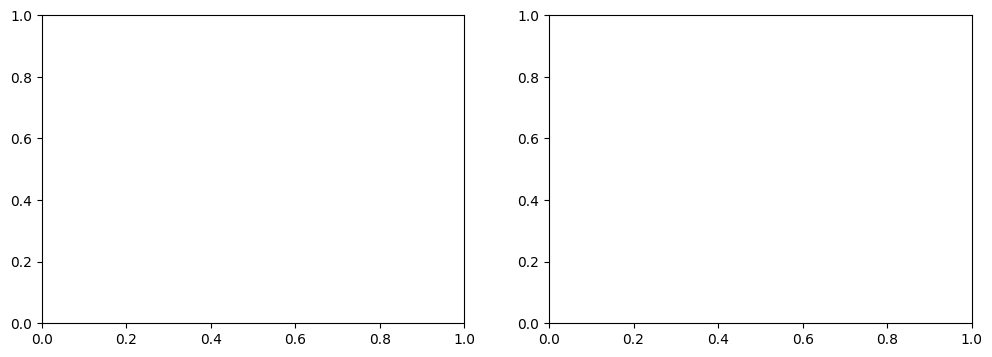

In [7]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history["train_loss"], label="Train")
ax1.plot(history["val_loss"], label="Val")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss")
ax1.legend()

ax2.plot(history["train_acc"], label="Train")
ax2.plot(history["val_acc"], label="Val")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.legend()

plt.tight_layout()
plt.show()


## 5. Evaluate


In [ ]:
import torch

# Load best model
model.load_state_dict(torch.load(MODEL_PATH))

# Evaluate on held-out test data
test_loader = get_test_loader(X_test, y_test)
results = test(model, test_loader)


## 6. Confusion Matrix


In [ ]:
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load label names
with open(DATA_DIR / "metadata.pkl", "rb") as f:
    metadata = pickle.load(f)
idx_to_label = metadata["idx_to_label"]
labels = [idx_to_label[i] for i in range(n_classes)]

# Confusion matrix
cm = confusion_matrix(results["labels"], results["predictions"])
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title(f"Confusion Matrix (Accuracy: {results['accuracy']:.1%})")
plt.tight_layout()
plt.show()


## 7. Cross-Validation (Optional)

Run k-fold cross-validation for a more reliable accuracy estimate with limited data.


In [5]:
# Run 5-fold cross-validation on training data
cv_results = cross_validate(
    model_class=CatMeowCNN,
    X=X_train,
    y=y_train,
    n_splits=5,
    epochs=100,
    learning_rate=0.001,
    batch_size=16,
    patience=30,
    n_classes=n_classes,  # passed to CatMeowCNN
)



Fold 1/5
Epoch   1/100 | Train: 2.3368, 0.141 | Val: 2.3111, 0.125
Epoch   2/100 | Train: 2.1670, 0.203 | Val: 2.3744, 0.125
Epoch   3/100 | Train: 2.0713, 0.344 | Val: 2.3131, 0.062
Epoch   4/100 | Train: 2.0291, 0.359 | Val: 2.1919, 0.062
Epoch   5/100 | Train: 1.9006, 0.312 | Val: 1.9965, 0.375
Epoch   6/100 | Train: 1.7943, 0.484 | Val: 1.9000, 0.312
Epoch   7/100 | Train: 1.7788, 0.438 | Val: 1.8615, 0.312
Epoch   8/100 | Train: 1.6778, 0.500 | Val: 1.7545, 0.375
Epoch   9/100 | Train: 1.5304, 0.562 | Val: 1.7296, 0.375
Epoch  10/100 | Train: 1.4305, 0.516 | Val: 1.6103, 0.438
Epoch  11/100 | Train: 1.3674, 0.641 | Val: 1.5987, 0.438
Epoch  12/100 | Train: 1.2952, 0.594 | Val: 1.5805, 0.438
Epoch  13/100 | Train: 1.1985, 0.656 | Val: 1.5510, 0.438
Epoch  14/100 | Train: 1.1638, 0.719 | Val: 1.8445, 0.375
Epoch  15/100 | Train: 1.0326, 0.703 | Val: 1.4001, 0.500
Epoch  16/100 | Train: 1.0081, 0.703 | Val: 1.4464, 0.312
Epoch  17/100 | Train: 0.8664, 0.797 | Val: 1.5831, 0.438
Epoc

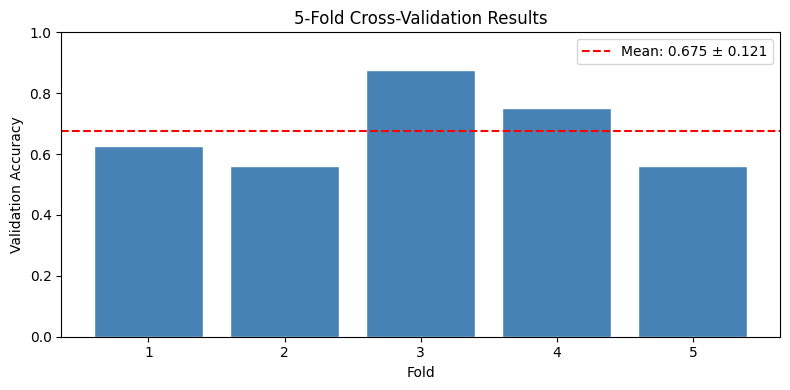


CV Accuracy: 67.5% ± 12.1%


In [8]:
# Visualize CV results
fig, ax = plt.subplots(figsize=(8, 4))
folds = [r["fold"] for r in cv_results["fold_results"]]
accs = cv_results["accuracies"]

ax.bar(folds, accs, color='steelblue', edgecolor='white')
ax.axhline(cv_results["mean_acc"], color='red', linestyle='--', 
           label=f'Mean: {cv_results["mean_acc"]:.3f} ± {cv_results["std_acc"]:.3f}')
ax.set_xlabel("Fold")
ax.set_ylabel("Validation Accuracy")
ax.set_title("5-Fold Cross-Validation Results")
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nCV Accuracy: {cv_results['mean_acc']:.1%} ± {cv_results['std_acc']:.1%}")


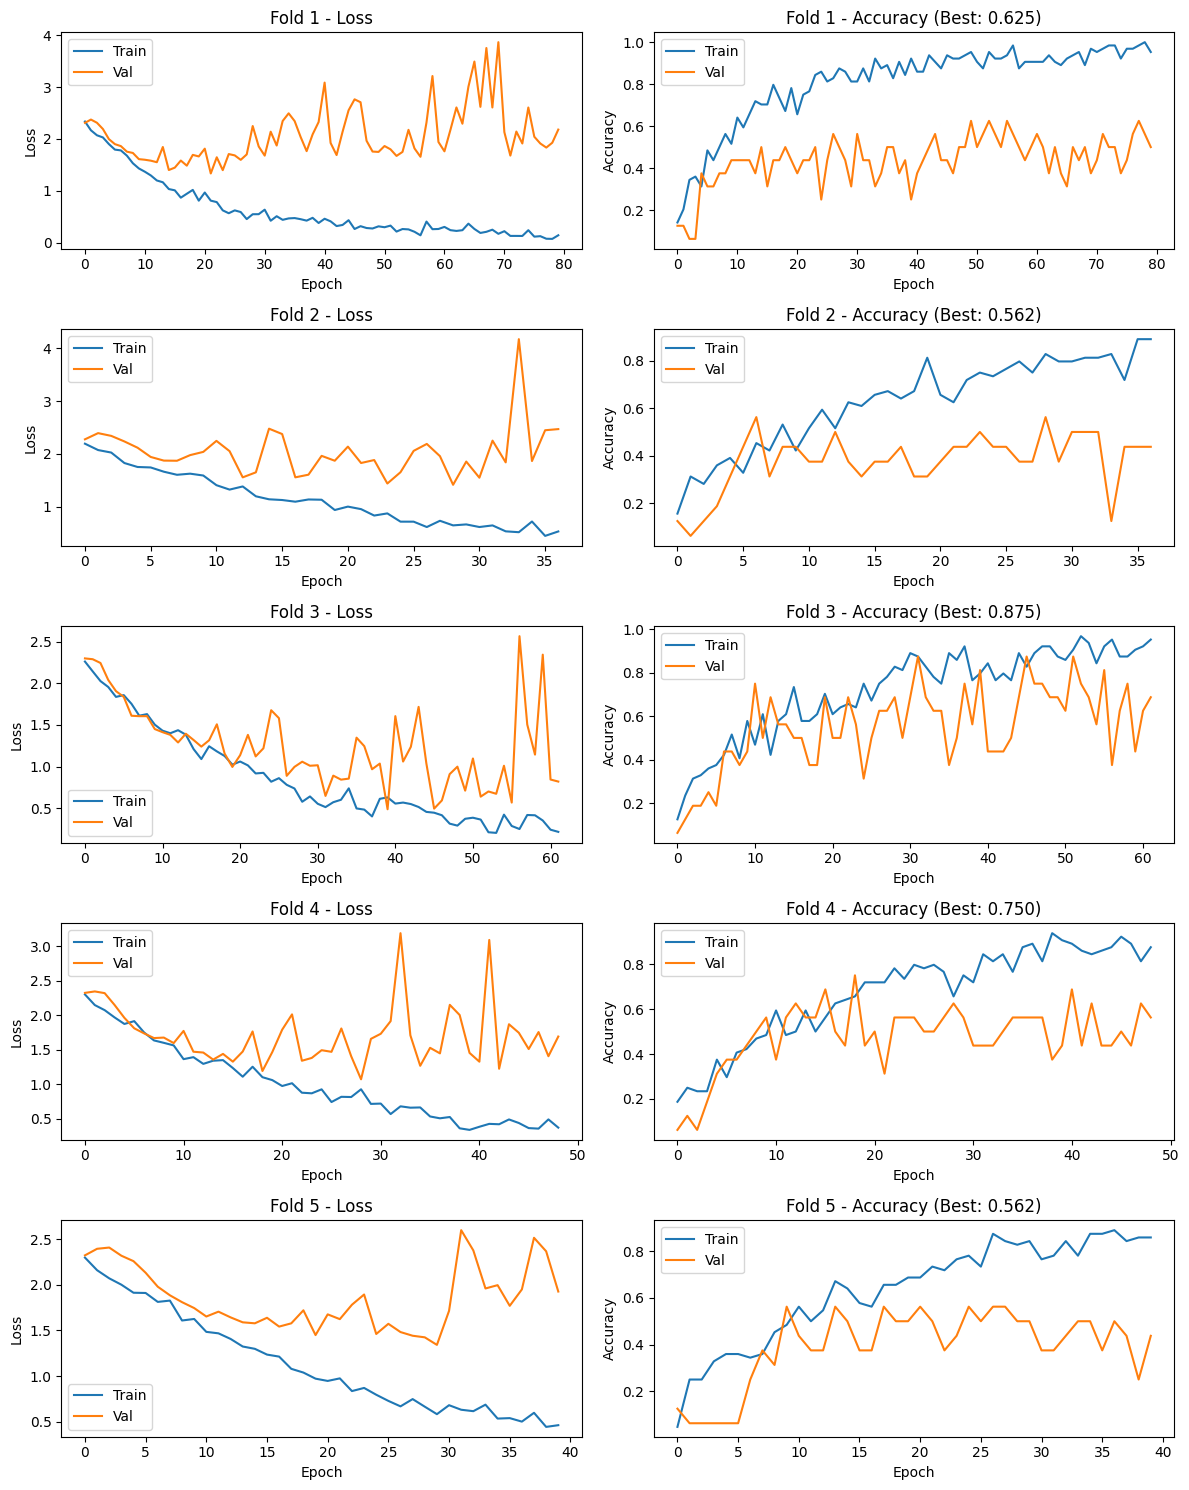

In [9]:
# Plot training curves for each fold
n_folds = len(cv_results["fold_results"])
fig, axes = plt.subplots(n_folds, 2, figsize=(12, 3 * n_folds))

for i, fold_result in enumerate(cv_results["fold_results"]):
    history = fold_result["history"]
    fold_num = fold_result["fold"]
    
    # Loss
    axes[i, 0].plot(history["train_loss"], label="Train")
    axes[i, 0].plot(history["val_loss"], label="Val")
    axes[i, 0].set_xlabel("Epoch")
    axes[i, 0].set_ylabel("Loss")
    axes[i, 0].set_title(f"Fold {fold_num} - Loss")
    axes[i, 0].legend()
    
    # Accuracy
    axes[i, 1].plot(history["train_acc"], label="Train")
    axes[i, 1].plot(history["val_acc"], label="Val")
    axes[i, 1].set_xlabel("Epoch")
    axes[i, 1].set_ylabel("Accuracy")
    axes[i, 1].set_title(f"Fold {fold_num} - Accuracy (Best: {fold_result['best_val_acc']:.3f})")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()
